In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import networkx as nx
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import subprocess
import pandas as pd

In [96]:
class Agent:
    def __init__(self, agent_id, preferences=None, budget=100, transact_probability=0.5):
        self.agent_id = agent_id
        self.preferences = preferences if preferences else []
        self.budget = budget  # currently a noop
        self.transact_probability = transact_probability
    
    def make_transaction(self, seller_nodes):
        for seller_node in self.preferences:
            if seller_node in seller_nodes and random.random() < self.transact_probability:
                return seller_node
        return None

class BuyerAgent(Agent):
    def __init__(self, agent_id, preferences=None, budget=100, transact_probability=0.5):
        super().__init__(agent_id, preferences, budget, transact_probability)

class SellerAgent(Agent):
    def __init__(self, agent_id, preferences=None, budget=100, transact_probability=0.5):
        super().__init__(agent_id, preferences, budget, transact_probability)

class NoshGraphSimulation:
    def __init__(self, initial_buyers, initial_sellers, min_buyers=2, min_sellers=2, seed=None):
        self.graph = nx.Graph()
        self.buyer_agents = {}
        self.seller_agents = {}
        self.min_buyers = min_buyers
        self.min_sellers = min_sellers
        self.rng = np.random.default_rng(seed)

        for buyer_id in initial_buyers:
            buyer_agent = BuyerAgent(buyer_id)
            self.buyer_agents[buyer_id] = buyer_agent
            self.graph.add_node(buyer_agent, bipartite=0, type='buyer')

        for seller_id in initial_sellers:
            seller_agent = SellerAgent(seller_id)
            self.seller_agents[seller_id] = seller_agent
            self.graph.add_node(seller_agent, bipartite=1, type='seller')
    
    def evolve_graph(self, add_delete_maintain_probs):
        add_prob, delete_prob, maintain_prob = add_delete_maintain_probs
        
        # Add or delete nodes
        prob = self.rng.random()
        if prob < add_prob:
            self.add_node()
        elif prob < add_prob + delete_prob:
            self.delete_node()

        # Simulate transactions and update weights
        for buyer_agent in self.buyer_agents.values():
            seller_nodes = [node for node in self.graph.neighbors(buyer_agent)]
            for seller_node in seller_nodes:
                if buyer_agent.make_transaction([seller_node.agent_id]):
                    edge = (buyer_agent, seller_node)
                    if self.graph.has_edge(*edge):
                        self.graph.edges[edge]['weight'] += 1
                    else:
                        self.graph.add_edge(*edge, weight=1)

    def add_node(self):
        new_node_id = max([agent.agent_id for agent in self.graph.nodes()]) + 1
        new_agent = Agent(new_node_id)
        if self.rng.random() < 0.5:
            self.graph.add_node(new_agent, bipartite=0, type='buyer')
            for existing_agent in self.graph.nodes():
                if self.graph.nodes[existing_agent]['bipartite'] == 1 and self.rng.random() < 0.3:
                    self.graph.add_edge(new_agent, existing_agent, weight=self.rng.integers(1, 5))
            self.buyer_agents[new_node_id] = new_agent
        else:
            self.graph.add_node(new_agent, bipartite=1, type='seller')
            for existing_agent in self.graph.nodes():
                if self.graph.nodes[existing_agent]['bipartite'] == 0 and self.rng.random() < 0.3:
                    self.graph.add_edge(existing_agent, new_agent, weight=self.rng.integers(1, 5))
            self.seller_agents[new_node_id] = new_agent

    def delete_node(self):
        # Determine randomly whether to delete a buyer or seller node
        delete_buyer = self.rng.random() < 0.5

        if delete_buyer:
            nodes_to_remove = list(self.buyer_agents.values())
            if len(nodes_to_remove) < self.min_buyers:
                return
        else:
            nodes_to_remove = list(self.seller_agents.values())
            if len(nodes_to_remove) < self.min_sellers:
                return

        if len(nodes_to_remove) > 0:
            node_to_remove = self.rng.choice(nodes_to_remove)
            self.graph.remove_node(node_to_remove)
            if delete_buyer:
                self.buyer_agents.pop(node_to_remove.agent_id, None)
            else:
                self.seller_agents.pop(node_to_remove.agent_id, None)
        else:
            # If it's not possible to delete a node of the chosen type, try the other type
            if delete_buyer:
                nodes_to_remove = list(self.seller_agents.values())
            else:
                nodes_to_remove = list(self.buyer_agents.values())

            if len(nodes_to_remove) > 0:
                node_to_remove = self.rng.choice(nodes_to_remove)
                self.graph.remove_node(node_to_remove)
                if delete_buyer:
                    self.seller_agents.pop(node_to_remove.agent_id, None)
                else:
                    self.buyer_agents.pop(node_to_remove.agent_id, None)

    def visualize(self, ax):
        # Create a layout for the bipartite graph
        buyer_nodes = [node for node, data in self.graph.nodes(data=True) if data['bipartite'] == 0]
        pos = nx.bipartite_layout(self.graph, buyer_nodes)
        
        # Extract agent IDs for labeling
        agent_labels = {node: node.agent_id for node in self.graph.nodes()}
        
        # Extract edge weights for labeling
        edge_labels = {(u, v): self.graph.edges[u, v]['weight'] for u, v in self.graph.edges()}
        
        # Get the nodes involved in edges
        nodes_in_edges = set(sum(self.graph.edges(), ()))

        # Filter out nodes without edges
        nodes_to_draw = [node for node in self.graph.nodes() if node in nodes_in_edges]

        # Draw the graph with agent IDs as labels and edge weights as labels
        nx.draw(self.graph, pos, ax=ax, nodelist=nodes_to_draw, labels=agent_labels, node_color='skyblue', node_size=500, font_size=10)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, ax=ax, font_color='red')
        ax.set_title("Bipartite Graph Visualization")

    def run(self, num_time_steps, add_delete_maintain_probs, create_video=False):
        frame_folder = 'frames'
        if not os.path.exists(frame_folder):
            os.makedirs(frame_folder, exist_ok=True)

        seller2weight_list = []
        for ii in range(num_time_steps):
            self.evolve_graph(add_delete_maintain_probs)

            seller2weight = self.get_seller_buyer_weights()
            seller2weight_list.append(seller2weight)

            if create_video:
                fig, ax = plt.subplots(figsize=(10, 6))
                self.visualize(ax)
                frame_filename = os.path.join(frame_folder, f'frame_{ii:03d}.png')
                plt.savefig(frame_filename)
                
                # Close the figure to release resources
                plt.close(fig)
            
        if create_video:
            # Call FFmpeg to combine frames into a video
            subprocess.call(['ffmpeg', '-y', '-framerate', '10', '-i', f'{frame_folder}/frame_%03d.png', '-c:v', 'libx264', '-r', '30', '-pix_fmt', 'yuv420p', 'output.mp4'])
            print("Video created: output.mp4")

        return pd.DataFrame(seller2weight_list)
        

    def get_seller_buyer_weights(self):
        """
        Get a dictionary mapping each seller's ID to a dictionary of buyer IDs and the weight of the edge connecting them.
        """
        seller_buyer_weights = {}

        for seller_agent in self.seller_agents.values():
            seller_id = seller_agent.agent_id
            seller_buyer_weights[seller_id] = {}

            for buyer_agent in self.buyer_agents.values():
                buyer_id = buyer_agent.agent_id
                edge_weight = self.graph.get_edge_data(seller_agent, buyer_agent, default={'weight': 0})['weight']
                seller_buyer_weights[seller_id][buyer_id] = edge_weight

        return seller_buyer_weights


In [97]:
# Initialize bipartite graph
initial_buyers = [1, 2, 3]
initial_sellers = [1, 2, 3]
simulation = NoshGraphSimulation(initial_buyers, initial_sellers)

# Set the probability vector for adding, deleting, or maintaining the graph in terms of number of nodes
add_delete_maintain_probs = [0.4, 0.3, 0.3]

# Run the simulation
num_time_steps = 100
seller2weight_df = simulation.run(num_time_steps, add_delete_maintain_probs)

In [99]:
def minting_fn(df):
    # df - a dataframe where rows are epochs, and columns represent each seller-id in the network at that epoch
    #   each entry of the dataframe is a dictionary of the weights of the edges between the seller and each buyer
    def sum_dict_values(row_dict):
        """
        Function to sum the values of all dictionaries in a row, ignoring NaN values.
        """
        total_sum = 0
        for d in row_dict:
            if isinstance(d, dict):
                total_sum += sum(filter(lambda x: not pd.isna(x), d.values()))
        return total_sum
    df['sum'] = df.apply(sum_dict_values, axis=1)
    return df

In [100]:
mint_df = minting_fn(seller2weight_df)

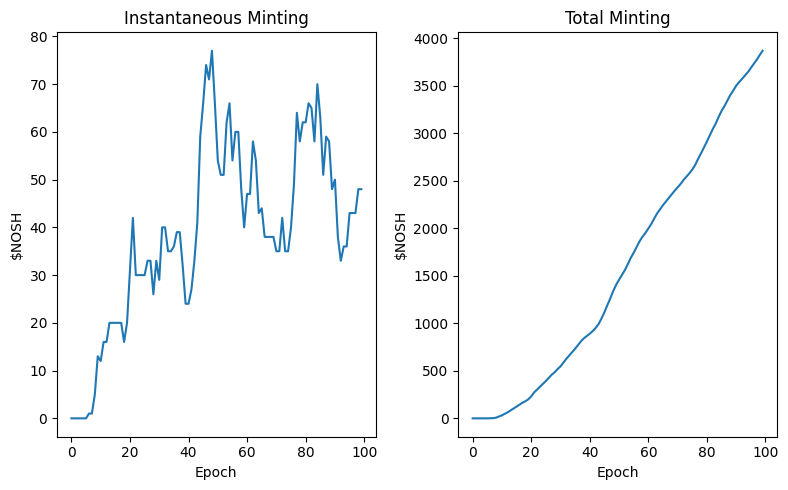

In [105]:
mint_by_epoch = mint_df['sum']
total_mint = mint_by_epoch.cumsum()
fig, ax = plt.subplots(figsize=(8, 5), nrows=1, ncols=2)

axx = ax[0]
axx.plot(mint_by_epoch)
axx.set_xlabel('Epoch')
axx.set_ylabel('$NOSH')
axx.set_title('Instantaneous Minting')

axx = ax[1]
axx.plot(mint_by_epoch.cumsum())
axx.set_xlabel('Epoch')
axx.set_ylabel('$NOSH')
axx.set_title('Total Minting')

plt.tight_layout()